# Chapter 2. 로지스틱 회귀
특정 문제에 알맞은 분류 알고리즘을 선택하려면 연습과 경험이 필요합니다. 알고리즘은 저마다 특징이 있고 일정한 가정을 전제로 합니다. **모든 경우에 뛰어난 성능을 낼 수 있는 분류 모델은 없습니다**. 실제로 최소한 몇 개의 학습 알고리즘 성능을 비교하고 해당 문제에 최선인 모델을 선택하는 것이 항상 권장됩니다.  
1단원에서 맛본 퍼셉트론만 보더라도, 머신러닝 분류 알고리즘을 배우기에 간단하고 좋은 모델임에는 분명하지만 클래스가 선형적으로 구분되지 않을 때 수렴할 수 없다는 단점이 있습니다. 학습률을 바꾸거나 에포크 횟수를 아무리 늘려봤자 퍼셉트론이 절대 수렴하지 못하는 데이터셋이 있고, 이는 이미 수학적으로 증명된 사실입니다. 이를 위해 더 강력핟 다른 알고리즘이 등장하는데, 그 중 하나가 로지스틱 회귀(logistic regression)가 되겠습니다. 이번 장에서는 로지스틱 회귀를 사용한 클래스 확률 모델링을 알아보겠습니다. 참고로, 이름이 회귀이지만 오늘 우리는 로지스틱 회귀를 회귀 문제가 아니라 분류 문제를 푸는 데 사용할 것입니다.

## 2.1 로지스틱 회귀의 이해
로지스틱 회귀 또한 퍼셉트론이나 아달린과 마찬가지로 이진 분류를 위한 선형 모델로 개발되었습니다. 물론 사이킷런의 로지스틱 회귀 메서드는 다중 분류도 지원하기는 하지만요. 실제로 우리는 **다중 클래스 설정**이라는 아이디어에서 출발해 로지스틱 회귀를 알아볼 것입니다. 이를 **다항 로지스틱 회귀**(multinomial logistic regression) 또는 **소프트맥스 회귀**(softmax regression)라고 부릅니다. 자세한 내용은 이 강의자료의 범위를 넘어가니 생략하고, 가장 핵심이 되는 수학 함수 하나만 소개하고 넘어가겠습니다. 바로 **시그모이드 함수**(sigmoid function)입니다.  
$$\phi\left(z\right)=\frac{1}{1+e^{-z}}$$  
여기서 $z$는 가중치와 입력(즉, 훈련 샘플의 특성)의 선형 조합으로 이루어진 최종 입력입니다. 즉, $z=\boldsymbol{w}^T\boldsymbol{x}=w_0x_0+w_1x_1+\cdots+w_mx_m$입니다. 시그모이드 함수의 그래프의 개형은 아래와 같습니다.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [3]:
z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

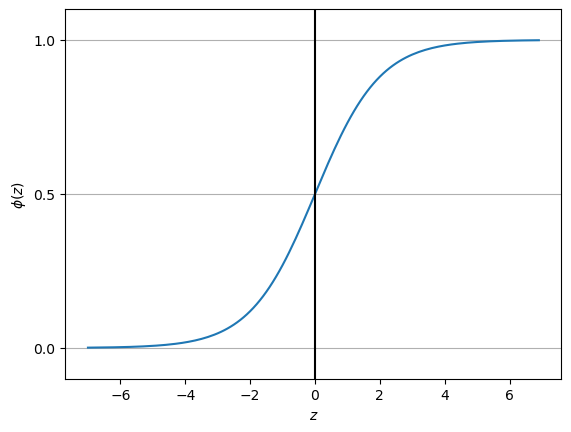

In [5]:
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('$z$')
plt.ylabel('$\phi(z)$')
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.show()

$z$가 무한대로 가면 $\phi\left(z\right)$는 1에 가까워지고, 반대로 $z$가 마이너스 무한대로 가면 $\phi\left(z\right)$는 0에 가까워집니다. 따라서 우리는 이 시그모이드 함수를 이용해 특정 샘플이 어떤 클래스에 속할 **확률**을 구할 수 있습니다. 예를 들어 어떤 붓꽃 샘플이 $\phi\left(z\right)=0.8$이라면 이 샘플이 그 클래스에 속할 확률이 80%라고 해석할 수 있습니다.  
이를 클래스로 나타내면 아래와 같습니다. 1장에서 본 아달린 클래스에서 `activation`의 함수를 시그모이드로 바꾸기만 하면 구현할 수 있습니다.

In [6]:
class LogisticRegressionGD(object):
    """경사 하강법을 사용한 로지스틱 회귀 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 로지스틱 비용 함수 값

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # 오차 제곱합 대신 로지스틱 비용을 계산합니다.
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """로지스틱 시그모이드 활성화 계산"""
        # 대신 from scipy.special import expit; expit(z) 을 사용할 수 있습니다.
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # 다음과 동일합니다.
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

다만, 이렇게 직접 구현한 로지스틱 모델은 이진 분류 문제에만 적용할 수 있다는 점에 주의하세요. `Iris-setosa`와 `Iris-versicolor` 붓꽃만 가지고 로지스틱 회귀 구현이 작동하는지 확인해보겠습니다.

In [7]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

In [14]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # 마커와 컬러맵을 설정합니다.
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor=None if idx==1 else 'black')

    # 테스트 샘플을 부각하여 그립니다.
    if test_idx:
        # 모든 샘플을 그립니다.
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0], X_test[:, 1],
                    facecolor='none',
                    edgecolor='black',
                    alpha=1.0, linewidth=1,
                    marker='o', s=100, 
                    label='test set')

In [9]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

In [10]:
lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)

In [11]:
lrgd.fit(X_train_01_subset, y_train_01_subset)

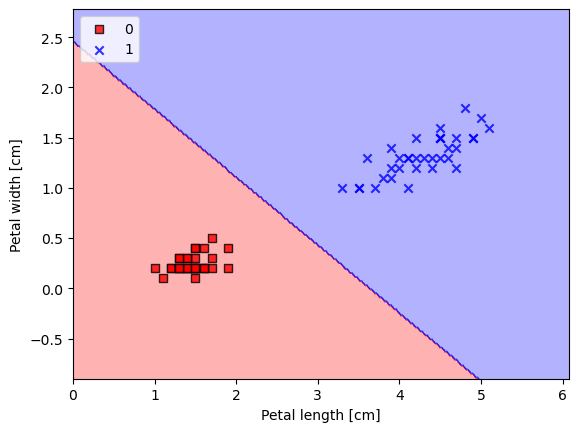

In [16]:
plot_decision_regions(X=X_train_01_subset, y=y_train_01_subset,
                      classifier=lrgd)
plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.show()

## 2.2 사이킷런을 사용한 로지스틱 회귀 모델 훈련
사이킷런에 구현된 로지스틱 회귀 모델은 다중 분류도 지원합니다. 다음 코드에서 `sklearn.linear_model.LogisticRegression`의 `fit` 메서드를 사용해 표준화된 붓꽃 데이터셋의 클래스 세 개를 대상으로 훈련을 하겠습니다.

In [17]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [19]:
from sklearn.linear_model import LogisticRegression

In [21]:
lr = LogisticRegression(C=100.0, random_state=1)

In [22]:
lr.fit(X_train_std, y_train)

LogisticRegression(C=100.0, random_state=1)

In [23]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

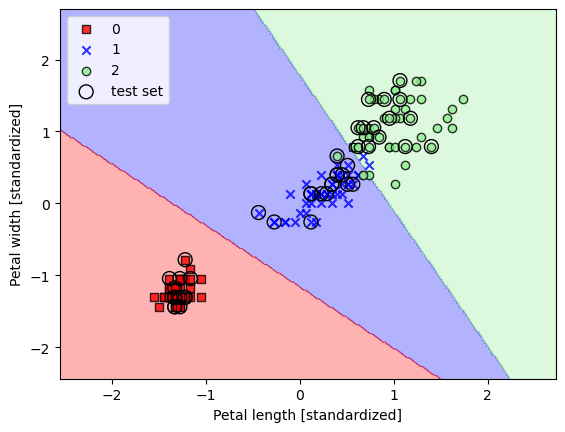

In [24]:
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel("Petal length [standardized]")
plt.ylabel("Petal width [standardized]")
plt.legend(loc='upper left')
plt.show()

잠깐. 위의 코드 중에서 `LogisticRegression`을 불러온 부분을 보니 이상한 인수가 보입니다. 저 매개변수 `C`는 도대체 뭐에요? 이 부분은 다음 절에서 오버피팅과 규제 개념을 설명하면서 다시 짚기로 하고, 일단은 클래스 소속 확률 이야기로 돌아와보도록 하죠.  
훈련 샘플이 어떤 클래스에 속할 확률은 `predict_proba` 메서드를 사용해 계산합니다. 처음 세 개 샘플의 확률은 아래와 같이 예측할 수 있습니다.

In [25]:
lr.predict_proba(X_test_std[:3, :])

array([[1.52213484e-12, 3.85303417e-04, 9.99614697e-01],
       [9.93560717e-01, 6.43928295e-03, 1.14112016e-15],
       [9.98655228e-01, 1.34477208e-03, 1.76178271e-17]])

첫 번째 행은 첫 번째 붓꽃의 클래스 소속 확률이고, 두 번째 행은 두 번째 꽃, 이런 식으로 각 클래스의 소속 확률을 각 행에 표시합니다. 당연하게도, 열(column)을 모두 합하면 1이 되어야 합니다.

In [26]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

첫 번째 행에서 가장 큰 값은 대략 0.999 정도입니다. 해석하자면, 첫 번째 샘플이 클래스 3, 즉 `Iris-virginica`에 속할 확률이 99.9%라는 뜻입니다. 이와 같이 행에서 가장 큰 값의 열이 예측 클래스 레이블이 됩니다. 예를 들어 넘파이의 `argmax` 함수를 쓰면 다음과 같이 씁니다.

In [27]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0], dtype=int64)

이전 코드에서는 확률을 계산하고 넘파이 `argmax` 함수를 사용해 직접 클래스 레이블로 바꾸었습니다. 하지만 보통 사이킷런 라이브러리를 사용할 때는 `predict` 메서드를 호출해서 훨씬 손쉽게 레이블을 얻을 수 있습니다.

In [28]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

마지막으로 샘플 하나의 클래스 레이블을 예측할 때 주의할 점이 있습니다. 사이킷런은 입력 데이터로 **2차원 배열만을** 기대합니다. 하나의 행을 2차원 포맷으로 먼저 변형해줘야 한다는 뜻입니다. 한 가지 방법은 넘파이의 `reshape` 메서드를 사용하는 것입니다. 예를 들어 아래와 같이 쓰는 것이죠.

In [29]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

## 2.3 규제를 사용하여 오버피팅 피하기
오버피팅(overfitting, 과대적합이라고도 번역)은 머신러닝과 딥러닝에서 자주 발생하는 문제점으로, 모델이 훈련 데이터로는 잘 동작하지만 테스트 데이터와 같이 본 적 없는 데이터로는 잘 예측되지 않는 현상을 뜻합니다. 예측 성능이 일반화되지 않았다고 볼 수도 있습니다. 모델이 오버피팅되었을 때 분산이 크다고 말합니다. 모델 파라미터가 너무 많아 주어진 데이터에서 너무 복잡한 모델을 만들기 때문입니다.  
비슷하게 모델이 언더피팅(underfitting, 과소적합)될 때도 있습니다. 이 경우는 반대로 편향이 큰 것을 의미하며, 훈련 데이터의 패턴조차 감지하지 못할 정도로 모델이 충분히 복잡하지 않다는 것을 의미합니다. 그러면 당연하게도 새로운 데이터에서도 성능이 낮을 것입니다.  
지금까지는 분류를 위한 선형 모델만 다뤄서 감이 잘 오지 않을 수 있지만, 이 두 문제는 아래 그림과 같이 복잡한 비선형 결정 경계와 선형 결정 경계를 비교하며 설명하는 것이 좋습니다.  
![그림 3-7](https://github.com/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch03/images/03_07.png?raw=true)  
실무에서는 편향과 분산이라는 두 마리 토끼를 모두 잡을 수 없기 때문에 어느 정도 타협(trade-off)을 하는 것을 목표로 합니다. 그 방법 중 한 가지는 규제(regulation)를 사용하여 모델의 복잡도를 조정하는 것입니다. 규제는 공선성(collinearity, 특성 간의 높은 상관관계)을 다루거나 데이터의 잡음을 제거하여 오버피팅을 방지하는 방법입니다.  
규제를 사용할 때는 컴퓨터가 계산하는 식에 규제 항(term)을 추가해서 함께 계산하도록 하는 것이 일반적입니다. 가장 널리 사용하는 규제 형태는 아래와 같은 **L2 규제**입니다(L2 축소 또는 가중치 감쇠라고도 합니다).  
$$\frac{\lambda}{2}\lVert \boldsymbol{w} \rVert^2 = \frac{\lambda}{2}\sum_{j=1}^m w_j^2$$  
이 식에서 $\lambda$(람다)는 규제 하이퍼파라미터입니다. 즉, 사용자가 바꿀 수 있는 값입니다. 이 규제 항은 비용 함수에 추가되어 적용되며, 모델 훈련 과정에서 가중치를 줄이는 역할을 합니다. $\lambda$를 사용하여 가중치를 작게 유지하면서 훈련 데이터에 얼마나 잘 맞출지를 조정할 수 있습니다. $\lambda$ 값을 증가하면 규제 강도가 높아집니다.  
그래서 앞서 `LogisticRegression`에서 등장한 `C` 얘기로 넘어가자면, 이 매개변수는 $\lambda$의 역수입니다. 결과적으로 역 규제 파라미터 `C`의 값을 감소시키면 규제 강도가 증가하는 것이죠. 두 가중치에 대해 L2 규제 효과를 그래프로 나타내보겠습니다.

In [30]:
weights, params = [], []

In [31]:
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10. ** c, random_state=1,
                            multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10. ** c)

In [32]:
weights = np.array(weights)
params = np.array(params)

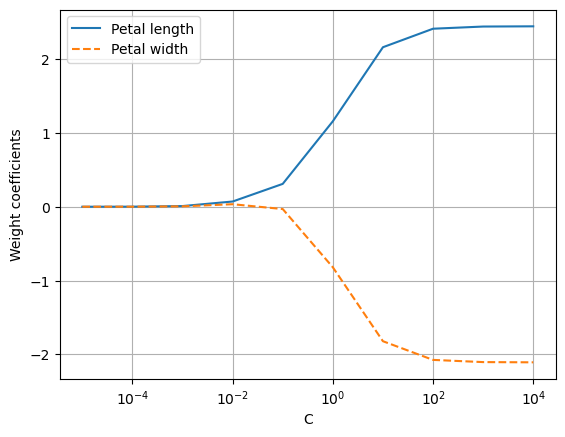

In [33]:
plt.plot(params, weights[:, 0],
         label='Petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='Petal width')
plt.ylabel("Weight coefficients")
plt.xlabel("C")
plt.legend(loc=0)
plt.xscale('log')
plt.grid()
plt.show()

이 코드를 실행하면 역 규제 매개변수 `C`의 값을 바꾸면서 열 개의 로지스틱 회귀 모델을 훈련합니다. 시연을 위해 모든 분류기에서 클래스 1의 가중치 값만 사용했습니다. 다중 분류에는 OvR(One-versus-Rest, 일대다) 기법을 사용했습니다. 결과 그래프에서 볼 수 있듯이 매개변수 `C`가 감소하면 가중치의 절대값이 줄어듭니다. 즉, 규제 강도가 증가합니다.